## Particle tracking through a transient flow system.

Application of a MODFLOW 6 particle-tracking (PRT) model to solve example 3 from the MODPATH 7 documentation.

### Problem setup

First import dependencies.

In [29]:
import os
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
from shapely.geometry import MultiPoint, LineString
import flopy
from flopy.utils.gridintersect import GridIntersect
import numpy as np
from pathlib import Path

sys.path.append(os.path.join("..", "common"))
import config
from figspecs import USGSFigure

Setup model name and workspace variables.

In [30]:
ws = config.base_ws
sim_name = "mp7-p03"
example_name = "ex-prt-" + sim_name
sim_ws = Path(ws) / example_name

nm_mf6 = sim_name
nm_prt = sim_name + "_prt"

Define flow model data.

In [31]:
nlay, nrow, ncol = 3, 21, 20
delr = delc = 500.0
top = 400.0
botm = [220.0, 200.0, 0.0]
laytyp = [1, 0, 0]
kh = [50.0, 0.01, 200.0]
kv = [10.0, 0.01, 20.0]
rch = 0.005
riv_h = 320.0
riv_z = 317.0
riv_c = 1.0e5

Define well data. Although this notebook will refer to layer/row/column indices starting at 1, indices in FloPy (and more generally in Python) are zero-based. A negative discharge indicates pumping, while a positive value indicates injection.

In [32]:
wells = [
    # layer, row, col, discharge
    (0, 10, 9, -75000),
    (2, 12, 4, -100000),
]

Define the drain location.

In [33]:
drain = (0, 14, (9, 20))

Configure locations for particle tracking to terminate. We have three explicitly defined termination zones:

- 2: the well in layer 1, at row 11, column 10
- 3: the well in layer 3, at row 13, column 5
- 4: the drain in layer 1, running through row 15 from column 10-20

MODFLOW 6 reserves zone number 1 to indicate that particles may move freely within the zone.

The river running through column 20 is also a termination zone, but it doesn't need to be defined separately since we are using the RIV package.

In [34]:
zone_maps = []

# zone 1 is the default (non-terminating regions)
def fill_zone_1():
    return np.ones((nrow, ncol), dtype=np.int32)

# zone map for layer 1
za = fill_zone_1()
za[wells[0][1:3]] = 2
za[drain[1], drain[2][0] : drain[2][1]] = 4
zone_maps.append(za)

# constant layer 2 (zone 1)
zone_maps.append(1)

# zone map for layer 3
za = fill_zone_1()
za[wells[1][1:3]] = 3
zone_maps.append(za)

Define particles to track. Particles are released from the top of a 2x2 square of cells in the upper left of the midel grid's top layer.

In [35]:
rel_minl = rel_maxl = 1
rel_minr = 2
rel_maxr = 3
rel_minc = 2
rel_maxc = 3
sd = flopy.modpath.CellDataType(
    drape=0
)  # particles added at top of cell (no drape)
pd = flopy.modpath.LRCParticleData(
    subdivisiondata=[sd],
    lrcregions=[
        [[rel_minl, rel_minr, rel_minc, rel_maxl, rel_maxr, rel_maxc]]
    ],
)
pg = flopy.modpath.ParticleGroupLRCTemplate(
    particlegroupname="PG1", particledata=pd, filename=f"{sim_name}.pg1.sloc"
)
pgs = [pg]
defaultiface = {"RECHARGE": 6, "ET": 6}

Create the MODFLOW 6 simulation and groundwater flow model.

In [36]:
# simulation
sim = flopy.mf6.MFSimulation(
    sim_name=sim_name, exe_name=config.mf6_exe, version="mf6", sim_ws=sim_ws
)

# temporal discretization
pd = [
    # perlen, nstp, tsmult
    (100000, 5000, 1),
    (36500, 10, 1),
    (100000, 1, 1),
]
nper = len(pd)
tdis = flopy.mf6.modflow.mftdis.ModflowTdis(
    sim, pname="tdis", time_units="DAYS", nper=nper, perioddata=pd
)

# groundwater flow (gwf) model
model_nam_file = f"{sim_name}.nam"
gwf = flopy.mf6.ModflowGwf(
    sim, modelname=sim_name, model_nam_file=model_nam_file, save_flows=True
)

# iterative model solver (ims) package
ims = flopy.mf6.modflow.mfims.ModflowIms(
    sim,
    pname="ims",
    complexity="SIMPLE",
    outer_dvclose=1e-6,
    inner_dvclose=1e-6,
    rcloserecord=1e-6,
)

# grid discretization
dis = flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(
    gwf,
    pname="dis",
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    length_units="FEET",
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
)

# initial conditions
ic = flopy.mf6.modflow.mfgwfic.ModflowGwfic(gwf, pname="ic", strt=top)

# node property flow
npf = flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(
    gwf, pname="npf", icelltype=laytyp, k=kh, k33=kv, save_flows=True, save_specific_discharge=True, save_saturation=True
)

# recharge
rch = flopy.mf6.modflow.mfgwfrcha.ModflowGwfrcha(gwf, recharge=rch)

# wells
def no_flow(w):
    return w[0], w[1], w[2], 0

wel = flopy.mf6.modflow.mfgwfwel.ModflowGwfwel(
    gwf,
    maxbound=1,
    stress_period_data={0: [no_flow(w) for w in wells], 1: wells, 2: wells},
)

# river
rd = [[(0, i, ncol - 1), riv_h, riv_c, riv_z] for i in range(nrow)]
flopy.mf6.modflow.mfgwfriv.ModflowGwfriv(
    gwf, stress_period_data={0: rd, 1: rd, 2: rd}
)

# drain (set auxiliary IFACE var to 6 for top of cell)
dd = [
    [drain[0], drain[1], i + drain[2][0], 322.5, 100000.0, 6]
    for i in range(drain[2][1] - drain[2][0])
]
drn = flopy.mf6.modflow.mfgwfdrn.ModflowGwfdrn(gwf, stress_period_data={0: dd})

# output control
headfile = f"{sim_name}.hds"
budgetfile = f"{sim_name}.cbb"
oc = flopy.mf6.modflow.mfgwfoc.ModflowGwfoc(
    gwf,
    pname="oc",
    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    head_filerecord=[headfile],
    budget_filerecord=[budgetfile],
)

Define particle release points.

In [37]:
from pprint import pprint

pts = np.linspace(0, 1, 5)
releasepts = []
zrpt = top
npts = 0
k = 0
for i in range(2, 4):
    for j in range(2, 4):
        for x in pts:
            for y in pts:
                xpt = (j + x) * delr
                ypt = (nrow - i - y) * delc
                rpt = [npts, k, i, j, xpt, ypt, zrpt]
                releasepts.append(rpt)
                npts += 1

pprint(releasepts)

[[0, 0, 2, 2, 1000.0, 9500.0, 400.0],
 [1, 0, 2, 2, 1000.0, 9375.0, 400.0],
 [2, 0, 2, 2, 1000.0, 9250.0, 400.0],
 [3, 0, 2, 2, 1000.0, 9125.0, 400.0],
 [4, 0, 2, 2, 1000.0, 9000.0, 400.0],
 [5, 0, 2, 2, 1125.0, 9500.0, 400.0],
 [6, 0, 2, 2, 1125.0, 9375.0, 400.0],
 [7, 0, 2, 2, 1125.0, 9250.0, 400.0],
 [8, 0, 2, 2, 1125.0, 9125.0, 400.0],
 [9, 0, 2, 2, 1125.0, 9000.0, 400.0],
 [10, 0, 2, 2, 1250.0, 9500.0, 400.0],
 [11, 0, 2, 2, 1250.0, 9375.0, 400.0],
 [12, 0, 2, 2, 1250.0, 9250.0, 400.0],
 [13, 0, 2, 2, 1250.0, 9125.0, 400.0],
 [14, 0, 2, 2, 1250.0, 9000.0, 400.0],
 [15, 0, 2, 2, 1375.0, 9500.0, 400.0],
 [16, 0, 2, 2, 1375.0, 9375.0, 400.0],
 [17, 0, 2, 2, 1375.0, 9250.0, 400.0],
 [18, 0, 2, 2, 1375.0, 9125.0, 400.0],
 [19, 0, 2, 2, 1375.0, 9000.0, 400.0],
 [20, 0, 2, 2, 1500.0, 9500.0, 400.0],
 [21, 0, 2, 2, 1500.0, 9375.0, 400.0],
 [22, 0, 2, 2, 1500.0, 9250.0, 400.0],
 [23, 0, 2, 2, 1500.0, 9125.0, 400.0],
 [24, 0, 2, 2, 1500.0, 9000.0, 400.0],
 [25, 0, 2, 3, 1500.0, 9500.0, 400.

Create the MODFLOW 6 PRT model.

In [38]:
# Instantiate the MODFLOW 6 prt model
prt = flopy.mf6.ModflowPrt(
    sim, modelname=nm_prt, model_nam_file="{}.nam".format(nm_prt)
)

# Instantiate the MODFLOW 6 prt discretization package
flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(
    prt, pname="dis",
    nlay=nlay, nrow=nrow, ncol=ncol,
    length_units="FEET",
    delr=delr, delc=delc,
    top=top, botm=botm,
)

# Instantiate the MODFLOW 6 prt model input package
porosity = 0.1
flopy.mf6.ModflowPrtmip(prt, pname="mip", porosity=porosity)

# Instantiate the MODFLOW 6 prt particle release point (prp) package
pd = {0: ["STEPS"] + [str(i + 1) for i in range(4500, 4510)], 1: [], 2: []}
flopy.mf6.ModflowPrtprp(
    prt, pname="prp1", filename="{}_1.prp".format(nm_prt),
    nreleasepts=len(releasepts), packagedata=releasepts,
    perioddata=pd,
)

# Instantiate the MODFLOW 6 prt output control package
budgetfile_prt = f"{nm_prt}.cbb"
budget_record = [budgetfile_prt]
flopy.mf6.ModflowPrtoc(
    prt,
    pname="oc",
    budget_filerecord=budget_record,
    saverecord=[("BUDGET", "ALL")],
)

# Instantiate the MODFLOW 6 prt flow model interface
pd = [
    ("GWFHEAD", headfile),
    ("GWFBUDGET", budgetfile)
]
flopy.mf6.ModflowPrtfmi(prt, packagedata=pd)

# Create the MODFLOW 6 gwf-prt model exchange
flopy.mf6.ModflowGwfprt(
    sim, exgtype="GWF6-PRT6",
    exgmnamea=nm_mf6, exgmnameb=nm_prt,
    filename="{}.gwfprt".format(nm_mf6),
)

# Create an explicit model solution (EMS) for the MODFLOW 6 prt model
ems = flopy.mf6.ModflowEms(
    sim, pname="ems",
    filename=f"{nm_prt}.ems",
)
sim.register_solution_package(ems, [prt.name])

Run the MODFLOW 6 simulation.

In [39]:
sim.write_simulation()
success, buff = sim.run_simulation(silent=True, report=True)
for line in buff:
    print(line)
assert success, "Failed to run simulation."

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing solution package ems...
  writing package mp7-p03.gwfprt...
  writing model mp7-p03...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 2 based on size of stress_period_data
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 21 based on size of stress_period_data
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 11 based on size of stress_period_data
    writing package oc...
  writing model mp7-p03_prt...
    writing model name file...
    writing package dis...
    writing package mip...
    writing package prp1...
    writing package oc...
    writing package fmi...
           

Define functions to load pathline data from the budget file created by the PRT model.

In [40]:
def load_mf6pathlines(cbb):

    ncpl = nrow * ncol
    dtype={'names':['x','y','z','time','k','particleid'],
           'formats':['<f4','<f4','<f4','<f4','<i4','<i4'],
          }
    upn = cbb.get_unique_package_names(decode=True)
    times = cbb.get_times()

    # Extract pathline data to a dictionary keyed on capture destination (well or river)
    mf6pathlines = {}
    for prpnam in upn:
        pdict = {}
        # For each time, read and parse particle data written by the prp
        # and add it to a dictionary keyed on a particle identifier consisting
        # of release point number and release time
        for totim in times:
            data = cbb.get_data(text='DATA-PRTCL', paknam=prpnam, totim=totim)
            for ploc in data[0]:
                # Particle data read from the binary output file are in terms
                # of one-based indexing; will convert to zero-based indexing
                irpt, node, xp, yp, zp, trelease, ttrack = [ploc[i] for i in (0, 1, 3, 4, 5, 6, 7)]
                irpt -= 1
                node -= 1
                kp = node // ncpl
                # issue(mf6): particle ids not assigned yet in mf6
                pathpoint = (xp, yp, zp, ttrack, kp, 0)
                key = (irpt, trelease)
                # Note that repeat locations written for terminated particles
                # are not filtered out here, though they could be
                if key not in pdict:
                    pdict[key] = [pathpoint]
                else:
                    pdict[key].append(pathpoint)
        # Sort the dictionary into separate dictionaries of formatted arrays
        # for pathlines ending at the well, the drain, and the river
        mf6pathlines['well'] = []
        mf6pathlines['river'] = []
        mf6pathlines['drain'] = []
        for key in pdict:
            path = np.core.records.fromarrays(np.array(pdict[key]).T, dtype=dtype)
            # issue(mf6): zone info not stored with particle locations, so using
            #   x coordinate to determine capture/endpoint zone in this problem.
            x = path['x'][-1]
            capture_zone = "river" if x > 5500 else "well"
            mf6pathlines[capture_zone].append(path)
                    
    # Return mf6pathlines
    return mf6pathlines

Create a `CellBudgetFile` object.

In [41]:
import flopy.utils.binaryfile as bf

cbb = bf.CellBudgetFile(sim_ws / budgetfile_prt)

Load pathlines from the budget file.

In [42]:
mf6pathlines = load_mf6pathlines(cbb)

Extract head data from the GWF model's output files.

In [43]:
hf = flopy.utils.HeadFile(sim_ws / headfile)
head = hf.get_data()

Plot the results.

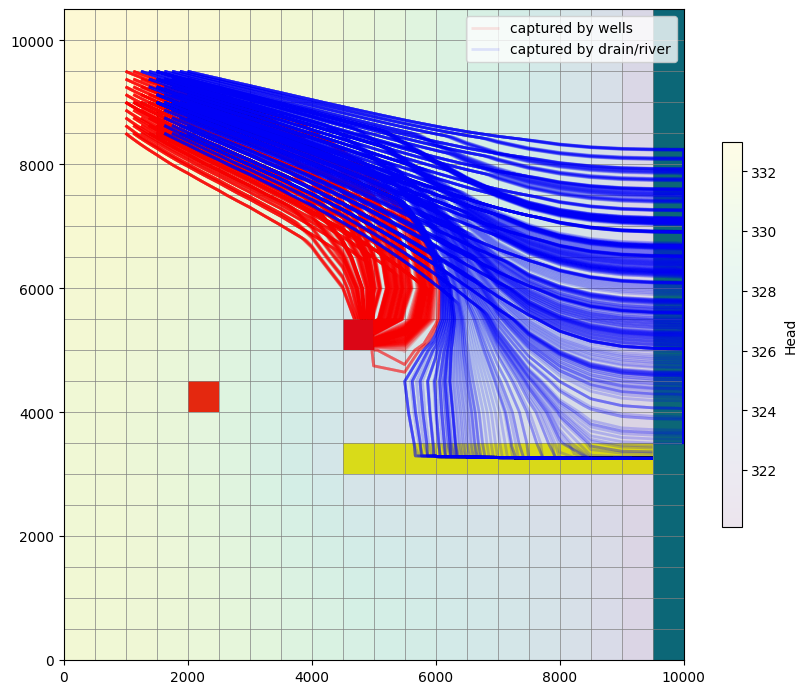

In [44]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

mv = flopy.plot.PlotMapView(model=gwf)
mv.plot_grid(lw=0.5)
mv.plot_bc("DRN")
mv.plot_bc("RIV")
mv.plot_bc("WEL", plotAll=True)
hd = mv.plot_array(head, alpha=0.1)
cb = plt.colorbar(hd, shrink=0.5)
cb.set_label("Head")
mv.plot_pathline(
    mf6pathlines['well'],
    layer="all",
    alpha=0.1,
    colors=["red"],
    lw=2,
    label="captured by wells",
)
mv.plot_pathline(
    mf6pathlines['river'],
    layer="all",
    alpha=0.1,
    colors=["blue"],
    lw=2,
    label="captured by drain/river",
)
# add_release(ax)
mv.ax.legend()
plt.show()